In [ ]:
#Mount drive and establish project directories
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Paths (update only if you placed files elsewhere)
GDRIVE_ROOT = '/content/drive/MyDrive/MIR/Project3'
MIR_DIR = f'{GDRIVE_ROOT}/MIR-1K'       # contains Wavfile/ etc
SRC_DIR = f'{GDRIVE_ROOT}/src'          # contains your src .py files

# Working dataset and model dirs (in Colab local filesystem)
WORK_DIR = '/content/mir_project'
DATASET_DIR = f'{WORK_DIR}/dataset'     # will contain train/val/test produced by preprocess.split_dataset
OUTPUT_DIR = f'{WORK_DIR}/output'       # will store outputs
MODEL_DIR = f'{WORK_DIR}/models'
LOG_DIR = f'{WORK_DIR}/logs'

import os
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

print('MIR_DIR =', MIR_DIR)
print('SRC_DIR =', SRC_DIR)
print('WORK_DIR =', WORK_DIR)


Mounted at /content/drive
MIR_DIR = /content/drive/MyDrive/MIR/Project3/MIR-1K
SRC_DIR = /content/drive/MyDrive/MIR/Project3/src
WORK_DIR = /content/mir_project


In [ ]:
#Install Dependencies
!pip install --quiet torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install --quiet mir-eval tqdm
!pip install --quiet torchcodec # Install missing TorchCodec dependency
!pip install --quiet torchsummary # Install torchsummary for model inspection

# confirm
import torch, torchaudio
print('torch', torch.__version__, 'cuda available:', torch.cuda.is_available())
print('torchaudio', torchaudio.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.9 MB/s eta 0:00:00
torch 2.9.0+cu126 cuda available: True
torchaudio 2.9.0+cu126


In [ ]:
#import src files
import sys, os
import importlib

# Ensure SRC_DIR is at the start of sys.path
if SRC_DIR not in sys.path or sys.path.index(SRC_DIR) != 0:
    if SRC_DIR in sys.path:
        sys.path.remove(SRC_DIR)
    sys.path.insert(0, SRC_DIR)

# List of modules to import (and potentially reload if they've changed)
required_modules = ['preprocess', 'train', 'test', 'evaluate', 'dataset', 'models', 'utils']

# Force reload specific modules that define classes for pickling, or those that depend on them
# This helps prevent 'PicklingError: not the same object' issues in interactive environments.
for m_name in ['models', 'train']:
    if m_name in sys.modules:
        del sys.modules[m_name]

# Import all necessary modules from src
import preprocess
import train
import test
import evaluate
import dataset
import models
import utils

print("All src modules ready.")

All src modules ready.


In [ ]:
#create training splits from MIR-1K
import preprocess
from pathlib import Path

wav_in_dir = os.path.join(MIR_DIR, 'Wavfile')
if not os.path.isdir(wav_in_dir):
    raise FileNotFoundError(f'Wavfile folder not found at expected path: {wav_in_dir}')

train_dir = os.path.join(DATASET_DIR, 'train')
val_dir   = os.path.join(DATASET_DIR, 'val')
test_dir  = os.path.join(DATASET_DIR, 'test')

# ensure target dirs exist
Path(train_dir).mkdir(parents=True, exist_ok=True)
Path(val_dir).mkdir(parents=True, exist_ok=True)
Path(test_dir).mkdir(parents=True, exist_ok=True)

# use the split_dataset helper from your preprocess.py
# It copies .wav files from wav_in_dir into ./dataset/{train,val,test}
preprocess.split_dataset(wav_in_dir, train_dir, val_dir, test_dir, ratio=(0.8, 0.1, 0.1), seed=42)

print("Train/val/test counts:")
print("train:", len(list(Path(train_dir).glob('*'))))
print("val:  ", len(list(Path(val_dir).glob('*'))))
print("test: ", len(list(Path(test_dir).glob('*'))))


Train/val/test counts:
train: 800
val:   100
test:  100


In [ ]:
# Cell 5/12 — train model to isolate vocals and accompaniment
import train
import shutil
import os

# common hyperparams (paper / src defaults)
common_kwargs = dict(
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    sample_rate=16000,        # resample to 16k (matches repo default)
    batch_size=64,
    learning_rate=3e-4,
    n_frame_in_segment=15,
    n_epochs=18,              # start with 25 for a faster initial run; increase to 100 for full replication
    seed=42,
    model_name='DAESkipConnections'
)

# Train accompaniment (channel 0)
print("Training accompaniment model (channel 0) ...")
train.train(
    dataset_path=DATASET_DIR,
    target_channel=0,
    model_path=os.path.join(MODEL_DIR,'model_background.ckpt'),
    **common_kwargs
)

# Train vocal (channel 1)
print("Training vocal model (channel 1) ...")
train.train(
    dataset_path=DATASET_DIR,
    target_channel=1,
    model_path=os.path.join(MODEL_DIR,'model_vocal.ckpt'),
    **common_kwargs
)

print("Training finished. Models saved in", MODEL_DIR)

# Backup models to OUTPUT_DIR and Drive to prevent retraining
print("Backing up checkpoints to OUTPUT_DIR and Google Drive...")
drive_models_dir = os.path.join(GDRIVE_ROOT, 'models_saved')
os.makedirs(drive_models_dir, exist_ok=True)

for ckpt in ['model_background.ckpt', 'model_vocal.ckpt']:
    src = os.path.join(MODEL_DIR, ckpt)
    # Copy to OUTPUT_DIR (local workspace)
    dst_out = os.path.join(OUTPUT_DIR, ckpt)
    shutil.copy(src, dst_out)
    # Copy to Drive (persistent storage)
    dst_drive = os.path.join(drive_models_dir, ckpt)
    shutil.copy(src, dst_drive)
    print(f"Saved {ckpt} to {dst_drive}")


Training accompaniment model (channel 0) ...
device: cuda
model name: DAESkipConnections


/usr/local/lib/python3.12/dist-packages/torchaudio/transforms/_transforms.py:95: UserWarning: `return_complex` argument is now deprecated and is not effective.`torchaudio.transforms.Spectrogram(power=None)` always returns a tensor with complex dtype. Please remove the argument in the function call.
  warnings.warn(
100%|██████████| 26/26 [00:00<00:00, 33.99it/s]


epoch: 1/18, training_loss = 6.98085, validation_loss = 5.02575


100%|██████████| 26/26 [00:00<00:00, 34.26it/s]


epoch: 2/18, training_loss = 4.23098, validation_loss = 3.89278


100%|██████████| 26/26 [00:00<00:00, 34.44it/s]


epoch: 3/18, training_loss = 3.49663, validation_loss = 3.35439


100%|██████████| 26/26 [00:00<00:00, 34.37it/s]


epoch: 4/18, training_loss = 3.11765, validation_loss = 3.12246


100%|██████████| 26/26 [00:00<00:00, 34.61it/s]


epoch: 5/18, training_loss = 2.89459, validation_loss = 2.87928


100%|██████████| 26/26 [00:00<00:00, 34.34it/s]


epoch: 6/18, training_loss = 2.73412, validation_loss = 2.83103


100%|██████████| 26/26 [00:00<00:00, 34.29it/s]


epoch: 7/18, training_loss = 2.57342, validation_loss = 2.66349


100%|██████████| 26/26 [00:00<00:00, 34.30it/s]


epoch: 8/18, training_loss = 2.46346, validation_loss = 2.60292


100%|██████████| 26/26 [00:00<00:00, 34.69it/s]


epoch: 9/18, training_loss = 2.35155, validation_loss = 2.63912


100%|██████████| 26/26 [00:00<00:00, 33.60it/s]


epoch: 10/18, training_loss = 2.27347, validation_loss = 2.46901


100%|██████████| 26/26 [00:00<00:00, 34.51it/s]


epoch: 11/18, training_loss = 2.21863, validation_loss = 2.71398


100%|██████████| 26/26 [00:00<00:00, 34.39it/s]


epoch: 12/18, training_loss = 2.13495, validation_loss = 2.38460


100%|██████████| 26/26 [00:00<00:00, 34.48it/s]


epoch: 13/18, training_loss = 2.06592, validation_loss = 2.36742


100%|██████████| 26/26 [00:00<00:00, 34.35it/s]


epoch: 14/18, training_loss = 2.02548, validation_loss = 2.32151


100%|██████████| 26/26 [00:00<00:00, 34.80it/s]


epoch: 15/18, training_loss = 1.96208, validation_loss = 2.40234


100%|██████████| 26/26 [00:00<00:00, 34.34it/s]


epoch: 16/18, training_loss = 1.91745, validation_loss = 2.30095


100%|██████████| 26/26 [00:00<00:00, 34.41it/s]


epoch: 17/18, training_loss = 1.87898, validation_loss = 2.28196


100%|██████████| 26/26 [00:00<00:00, 33.95it/s]


epoch: 18/18, training_loss = 1.83608, validation_loss = 2.26739
Training vocal model (channel 1) ...
device: cuda
model name: DAESkipConnections


100%|██████████| 26/26 [00:01<00:00, 25.68it/s]


epoch: 1/18, training_loss = 7.19502, validation_loss = 4.82877


100%|██████████| 26/26 [00:00<00:00, 26.05it/s]


epoch: 2/18, training_loss = 4.18695, validation_loss = 3.92790


100%|██████████| 26/26 [00:01<00:00, 25.78it/s]


epoch: 3/18, training_loss = 3.58065, validation_loss = 3.41727


100%|██████████| 26/26 [00:01<00:00, 25.82it/s]


epoch: 4/18, training_loss = 3.13411, validation_loss = 3.20836


100%|██████████| 26/26 [00:01<00:00, 25.80it/s]


epoch: 5/18, training_loss = 2.83544, validation_loss = 2.87132


100%|██████████| 26/26 [00:01<00:00, 25.55it/s]


epoch: 6/18, training_loss = 2.65011, validation_loss = 2.70669


100%|██████████| 26/26 [00:01<00:00, 25.80it/s]


epoch: 7/18, training_loss = 2.49875, validation_loss = 2.63266


100%|██████████| 26/26 [00:01<00:00, 25.97it/s]


epoch: 8/18, training_loss = 2.39847, validation_loss = 2.53150


100%|██████████| 26/26 [00:00<00:00, 26.39it/s]


epoch: 9/18, training_loss = 2.26393, validation_loss = 2.47974


100%|██████████| 26/26 [00:01<00:00, 25.73it/s]


epoch: 10/18, training_loss = 2.18104, validation_loss = 2.40601


100%|██████████| 26/26 [00:01<00:00, 25.79it/s]


epoch: 11/18, training_loss = 2.08674, validation_loss = 2.37323


100%|██████████| 26/26 [00:01<00:00, 25.69it/s]


epoch: 12/18, training_loss = 2.02006, validation_loss = 2.29750


100%|██████████| 26/26 [00:01<00:00, 25.86it/s]


epoch: 13/18, training_loss = 1.94042, validation_loss = 2.29230


100%|██████████| 26/26 [00:01<00:00, 25.65it/s]


epoch: 14/18, training_loss = 1.89208, validation_loss = 2.24825


100%|██████████| 26/26 [00:01<00:00, 25.99it/s]


epoch: 15/18, training_loss = 1.80182, validation_loss = 2.34539


100%|██████████| 26/26 [00:01<00:00, 25.61it/s]


epoch: 16/18, training_loss = 1.75806, validation_loss = 2.14244


100%|██████████| 26/26 [00:01<00:00, 25.65it/s]


epoch: 17/18, training_loss = 1.71753, validation_loss = 2.13886


100%|██████████| 26/26 [00:01<00:00, 25.71it/s]

epoch: 18/18, training_loss = 1.67345, validation_loss = 2.07552
Training finished. Models saved in /content/mir_project/models
Backing up checkpoints to OUTPUT_DIR and Google Drive...
Saved model_background.ckpt to /content/drive/MyDrive/MIR/Project3/models_saved/model_background.ckpt
Saved model_vocal.ckpt to /content/drive/MyDrive/MIR/Project3/models_saved/model_vocal.ckpt


In [ ]:
#inference w masking to separaete source into vocals and accompaniment
import torch
import torchaudio
import utils
import preprocess
from pathlib import Path
import os
import warnings
import mir_eval
import numpy as np
import tqdm

warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Patch load_model to support older pickles if needed
_original_utils_load_model = utils.load_model
def load_model_with_weights_only_false(model_path):
    model_path = Path(model_path)
    if not model_path.exists():
        raise FileNotFoundError(f'Model not found at {model_path}')
    return torch.load(model_path, weights_only=False)
utils.load_model = load_model_with_weights_only_false

# Load models
model_vocal = utils.load_model(os.path.join(MODEL_DIR,'model_vocal.ckpt')).to(device).eval()
model_background = utils.load_model(os.path.join(MODEL_DIR,'model_background.ckpt')).to(device).eval()
models = [model_background, model_vocal]

def inference_with_masking(models, in_wav_path, out_dir, n_frame_in_segment=15, n_fft=2048, win_length=2048, hop_length=512, sample_rate=16000, batch_size=64, resample=True):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Convert to spectrogram
    spectrogram, time_pad = preprocess.convert_to_spectrogram(Path(in_wav_path), n_fft, win_length, hop_length, sample_rate, mono=True, resample=resample)
    magnitude, phase = torch.abs(spectrogram), torch.angle(spectrogram)

    # Split into segments
    data, _ = preprocess.split_tensors_with_padding(magnitude, n_frame_in_segment)

    # Shape Fix: Ensure (N, 1, Freq, Time). If (N, 1, Time, Freq) [Time=15, Freq=1025], permute.
    if data.shape[3] == n_fft // 2 + 1:
         data = data.permute(0, 1, 3, 2)

    preds_per_model = []
    for model in models:
        model_preds = []
        for start in range(0, data.shape[0], batch_size):
            end = min(start + batch_size, data.shape[0])
            x = data[start:end].to(device)
            with torch.no_grad():
                # ReLU Fix: Enforce non-negative magnitude predictions
                y = torch.relu(model(x))
            model_preds.append(y.cpu()) # Move to CPU to save GPU memory

        # Reconstruct spectrogram: (N, 1, Freq, Time) -> (1, Freq, Total_Time)
        full_preds = torch.cat(model_preds, dim=0)
        pred_spec = torch.cat(torch.unbind(full_preds, dim=0), dim=-1)
        preds_per_model.append(pred_spec)

    # Masking
    stacked_preds = torch.stack(preds_per_model, dim=0)
    if stacked_preds.shape[-1] > magnitude.shape[-1]:
        stacked_preds = stacked_preds[..., :magnitude.shape[-1]]

    masks = stacked_preds / (torch.sum(stacked_preds, dim=0) + 1e-8)
    estimated_specs = masks * magnitude.unsqueeze(0)

    # Inverse STFT
    istft = torchaudio.transforms.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)
    waveforms = []
    for i in range(len(estimated_specs)):
        wav = istft(torch.polar(estimated_specs[i], phase))
        if time_pad > 0: wav = wav[:, :-time_pad]
        waveforms.append(wav)

    # Save to local output dir (will be copied to Drive later)
    out_base = out_dir / Path(in_wav_path).stem
    bg_path = str(out_base) + '_background.wav'
    vocal_path = str(out_base) + '_vocal.wav'
    torchaudio.save(bg_path, waveforms[0], sample_rate)
    torchaudio.save(vocal_path, waveforms[1], sample_rate)

    return bg_path, vocal_path

def find_best_song(models, test_dir, n_fft=2048, win_length=2048, hop_length=512):
    test_dir = Path(test_dir)
    if not test_dir.exists():
        print(f"Directory {test_dir} does not exist.")
        return

    files = sorted(list(test_dir.glob('*.wav')))
    if not files:
        print("No wav files found in test directory.")
        return

    best_song = None
    best_avg_score = -float('inf')
    best_metrics = {}

    print(f"Evaluating {len(files)} songs to find the best one...")

    # Create ISTFT once
    istft = torchaudio.transforms.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)

    for f in tqdm.tqdm(files):
        # Load GT (Assume Ch0=Acc, Ch1=Voc)
        wav, sr = torchaudio.load(f)
        if sr != 16000:
            wav = torchaudio.functional.resample(wav, sr, 16000)

        ref_sources = wav.numpy()
        if ref_sources.shape[0] > 2:
            ref_sources = ref_sources[:2, :]

        # --- Separation (In-Memory) ---
        spectrogram, time_pad = preprocess.convert_to_spectrogram(f, n_fft, win_length, hop_length, 16000, mono=True, resample=True)
        magnitude, phase = torch.abs(spectrogram), torch.angle(spectrogram)

        # Split
        data, _ = preprocess.split_tensors_with_padding(magnitude, 15)
        if data.shape[3] == n_fft // 2 + 1:
             data = data.permute(0, 1, 3, 2)

        # Inference
        preds_per_model = []
        for model in models:
            model_preds = []
            for start in range(0, data.shape[0], 64):
                end = min(start + 64, data.shape[0])
                x = data[start:end].to(device)
                with torch.no_grad():
                    y = torch.relu(model(x))
                model_preds.append(y.cpu())

            full = torch.cat(model_preds, dim=0)
            preds_per_model.append(torch.cat(torch.unbind(full, dim=0), dim=-1))

        # Masking
        stk = torch.stack(preds_per_model, dim=0)
        if stk.shape[-1] > magnitude.shape[-1]:
            stk = stk[..., :magnitude.shape[-1]]
        masks = stk / (stk.sum(dim=0) + 1e-8)
        est_specs = masks * magnitude.unsqueeze(0)

        # Reconstruction
        est_wavs = []
        for i in range(2):
            w = istft(torch.polar(est_specs[i], phase))
            if time_pad > 0: w = w[:, :-time_pad]
            est_wavs.append(w.squeeze(0).numpy())
        est_sources = np.stack(est_wavs)

        # --- Evaluation ---
        length = min(ref_sources.shape[1], est_sources.shape[1])
        sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(
            ref_sources[:, :length],
            est_sources[:, :length],
            compute_permutation=False
        )

        # Average of 6 metrics: Acc_SDR, Acc_SIR, Acc_SAR, Voc_SDR, Voc_SIR, Voc_SAR
        avg_score = (np.sum(sdr) + np.sum(sir) + np.sum(sar)) / 6.0

        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_song = f.name
            best_metrics = {
                'SDR': sdr, 'SIR': sir, 'SAR': sar
            }

    print("\n" + "="*50)
    print(f"Best Song: {best_song}")
    print(f"Highest Average Score (across 6 metrics): {best_avg_score:.4f}")
    print("Detailed Metrics:")
    print(f"  Accompaniment - SDR: {best_metrics['SDR'][0]:.2f}, SIR: {best_metrics['SIR'][0]:.2f}, SAR: {best_metrics['SAR'][0]:.2f}")
    print(f"  Vocals        - SDR: {best_metrics['SDR'][1]:.2f}, SIR: {best_metrics['SIR'][1]:.2f}, SAR: {best_metrics['SAR'][1]:.2f}")
    print("="*50)

# Execute finding best song if DATASET_DIR is available
if 'DATASET_DIR' in globals():
    find_best_song(models, os.path.join(DATASET_DIR, 'test'))
else:
    print("DATASET_DIR global variable not found. Make sure setup cells are run.")

Using device: cuda
Evaluating 100 songs to find the best one...


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Best Song: titon_2_01.wav
Highest Average Score (across 6 metrics): 17.1775
Detailed Metrics:
  Accompaniment - SDR: 15.01, SIR: 19.52, SAR: 16.96
  Vocals        - SDR: 14.95, SIR: 20.03, SAR: 16.60


Evaluating 100 files...


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]



METRIC STATISTICS

>>> Accompaniment <<<
SDR: Min=  3.83 | Max= 15.01 | IQR=  2.15
SIR: Min=  4.87 | Max= 19.52 | IQR=  3.35
SAR: Min=  8.76 | Max= 16.96 | IQR=  1.44

>>> Vocal <<<
SDR: Min=  3.31 | Max= 14.95 | IQR=  2.45
SIR: Min=  4.86 | Max= 20.30 | IQR=  3.28
SAR: Min=  7.79 | Max= 16.60 | IQR=  1.78



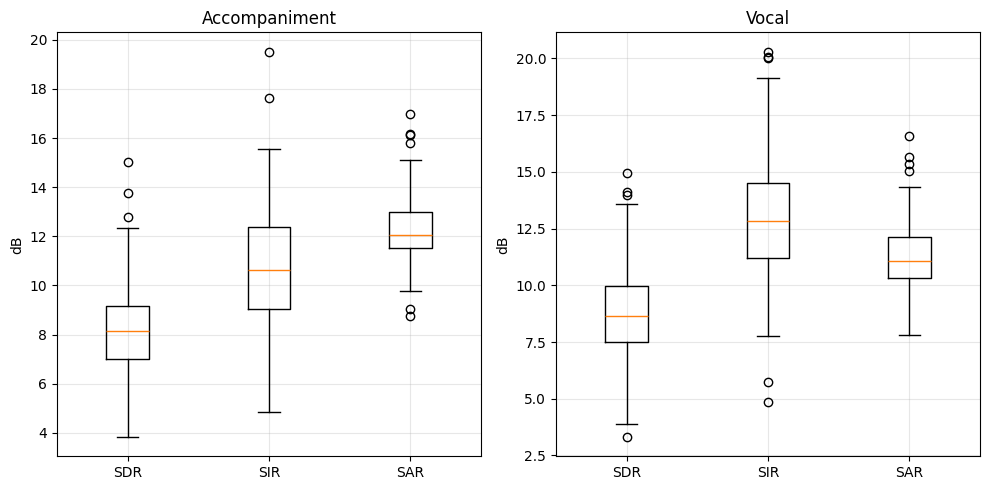

In [ ]:
#evaluate SDR, SIR, SAR. compares spectrogram of original audio with the separated audio waveforms
#SDR is signal to distorition ratio  is "overall performance"
#SAR is signal to artifact ratio is how well model avoids artifiacts when separating
#SIR is signal to interference ratio is how well sources are separated based on remaining interference btwn sources

import torch
import torchaudio
import mir_eval
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm
import preprocess
import warnings
warnings.filterwarnings("ignore")

def evaluate_and_plot(models, test_dir, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    files = sorted(list(Path(test_dir).glob('*.wav')))

    # Store metrics: Acc (idx 0), Voc (idx 1)
    metrics = {0: {'SDR':[], 'SIR':[], 'SAR':[]}, 1: {'SDR':[], 'SIR':[], 'SAR':[]}}

    print(f"Evaluating {len(files)} files...")
    device = next(models[0].parameters()).device

    for f in tqdm.tqdm(files):
        # 1. Load GT & Prep Input (MIR-1K: Ch0=Acc, Ch1=Voc)
        wav, sr = torchaudio.load(f)
        ref_sources = wav.numpy()

        # 2. Inference Prep
        spec, pad = preprocess.convert_to_spectrogram(f, 2048, 2048, 512, 16000, mono=True)
        mag, phase = spec.abs(), spec.angle()

        # Segment & Permute if needed (N, 1, F, T)
        data, _ = preprocess.split_tensors_with_padding(mag, 15)
        if data.shape[3] == 1025: data = data.permute(0, 1, 3, 2)

        # 3. Run Models
        ests = []
        for model in models:
            preds = []
            for i in range(0, len(data), 64):
                batch = data[i:i+64].to(device)
                with torch.no_grad(): preds.append(torch.relu(model(batch)).cpu())
            full = torch.cat(preds, dim=0)
            ests.append(torch.cat(torch.unbind(full, dim=0), dim=-1))

        # 4. Reconstruct with Masking
        stk = torch.stack(ests, dim=0)
        stk = stk[..., :mag.shape[-1]]
        masks = stk / (stk.sum(dim=0) + 1e-8)
        est_specs = masks * mag.unsqueeze(0)

        istft = torchaudio.transforms.InverseSpectrogram(n_fft=2048, win_length=2048, hop_length=512)
        est_wavs = []
        for i in range(2):
            w = istft(torch.polar(est_specs[i], phase))
            if pad > 0: w = w[:, :-pad]
            est_wavs.append(w.squeeze(0).numpy())
        est_sources = np.stack(est_wavs)

        # 5. Save
        torchaudio.save(out_dir / f"{f.stem}_bg.wav", torch.from_numpy(est_sources[0]).unsqueeze(0), 16000)
        torchaudio.save(out_dir / f"{f.stem}_voc.wav", torch.from_numpy(est_sources[1]).unsqueeze(0), 16000)

        # 6. Evaluate
        l = min(ref_sources.shape[1], est_sources.shape[1])
        sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[:, :l], est_sources[:, :l], compute_permutation=False)
        for i in range(2):
            metrics[i]['SDR'].append(sdr[i]); metrics[i]['SIR'].append(sir[i]); metrics[i]['SAR'].append(sar[i])

    # 7. Calculate Statistics (IQR, Min, Max)
    print("\n" + "="*50)
    print("METRIC STATISTICS")
    print("="*50)
    for i, name in enumerate(['Accompaniment', 'Vocal']):
        print(f"\n>>> {name} <<<")
        for m_name in ['SDR', 'SIR', 'SAR']:
            vals = np.array(metrics[i][m_name])
            _min = np.min(vals)
            _max = np.max(vals)
            q25, q75 = np.percentile(vals, [25, 75])
            iqr = q75 - q25
            print(f"{m_name:>3}: Min={_min:6.2f} | Max={_max:6.2f} | IQR={iqr:6.2f}")
    print("="*50 + "\n")

    # 8. Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, title in enumerate(['Accompaniment', 'Vocal']):
        d = [metrics[i]['SDR'], metrics[i]['SIR'], metrics[i]['SAR']]
        axes[i].boxplot(d, labels=['SDR', 'SIR', 'SAR'])
        axes[i].set_title(title)
        axes[i].set_ylabel('dB')
        axes[i].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run
evaluate_and_plot(models, os.path.join(DATASET_DIR, 'test'), os.path.join(OUTPUT_DIR, 'masked_outputs'))

In [ ]:
# Copy all outputs (including separated wav files) to Google Drive
import shutil

# Define destination in Drive
drive_save_path = os.path.join(GDRIVE_ROOT, 'outputs_saved')

print(f"Copying {OUTPUT_DIR} to {drive_save_path} ...")
shutil.copytree(OUTPUT_DIR, drive_save_path, dirs_exist_ok=True)
print("files saved to drive.")

Copying /content/mir_project/output to /content/drive/MyDrive/MIR/Project3/outputs_saved ...
files saved to drive.
